In [222]:
import sys
sys.path.append("../../src/")
import uncertainpy.gradual as grad
import time
import random
random.seed(0)

In [223]:
start_time = time.time()

In [224]:
from itertools import combinations

# generate random combination with number n
def combine(temp_list, n):
    return list(combinations(temp_list, n))

In [225]:
# generate random sublist from current list
def generate_new_list(original_list):
    new_list = []
    for element in original_list:
        if random.choice([True, False]):
            new_list.append(element)
    return new_list

In [226]:
# set semantics and compute strength of arguments

filename = "../../bags/approx_cyclic.bag"
model = grad.semantics.QuadraticEnergyModel()
model.approximator = grad.algorithms.RK4(model)
model.BAG = grad.BAG(filename)
model.solve(delta=10e-2, epsilon=10e-4, verbose=True, generate_plot=False)

QuadraticEnergyModel, RK4
Time: 6.399999999999993
Argument(name=0, weight=0.9827854760376531, strength=0.9827854760376531)
Argument(name=1, weight=0.8102172359965896, strength=0.8608310125873664)
Argument(name=2, weight=0.9021659504395827, strength=0.8838267892852679)
Argument(name=3, weight=0.3101475693193326, strength=0.3101475693193326)
Argument(name=4, weight=0.7298317482601286, strength=0.5887171843622665)
Argument(name=5, weight=0.8988382879679935, strength=0.778368982112742)
Argument(name=6, weight=0.6839839319154413, strength=0.8324243649707855)
Argument(name=7, weight=0.47214271545271336, strength=0.47214271545271336)
Argument(name=8, weight=0.1007012080683658, strength=0.09911517125978864)
Argument(name=9, weight=0.4341718354537837, strength=0.22658175597224905)
Argument(name=10, weight=0.6108869734438016, strength=0.7070459574175583)
Argument(name=11, weight=0.9130110532378982, strength=0.9130110532378982)
Argument(name=12, weight=0.9666063677707588, strength=0.9845227406302

0.0009315376545219745

In [227]:
# get all the attacks and supports in QBAF
att_relation = model.BAG.get_attacks()
sup_relation = model.BAG.get_supports()
all_relation = att_relation + sup_relation

In [228]:
# rename relation concisely
all_relation_new = []
for i in all_relation:
    if str(i)[0:3]=="Att":
        all_relation_new.append(("att",str(i.get_attacker().get_name()),str(i.get_attacked().get_name())))
    elif str(i)[0:3]=="Sup":
        all_relation_new.append(("sup",str(i.get_supporter().get_name()),str(i.get_supported().get_name())))

In [229]:
# set topic argument
topic_a = "14"
topic_arg = model.BAG.arguments[topic_a]

In [230]:
# compute strength for all arguments
for arg in model.BAG.arguments.values():
    print((arg.name,arg.initial_weight,arg.strength))

('0', 0.9827854760376531, 0.9827854760376531)
('1', 0.8102172359965896, 0.8608310125873664)
('2', 0.9021659504395827, 0.8838267892852679)
('3', 0.3101475693193326, 0.3101475693193326)
('4', 0.7298317482601286, 0.5887171843622665)
('5', 0.8988382879679935, 0.778368982112742)
('6', 0.6839839319154413, 0.8324243649707855)
('7', 0.47214271545271336, 0.47214271545271336)
('8', 0.1007012080683658, 0.09911517125978864)
('9', 0.4341718354537837, 0.22658175597224905)
('10', 0.6108869734438016, 0.7070459574175583)
('11', 0.9130110532378982, 0.9130110532378982)
('12', 0.9666063677707588, 0.9845227406302507)
('13', 0.47700977655271704, 0.48874845832221875)
('14', 0.8653099277716401, 0.3508586351558781)


In [231]:
# approximate attribution for a random edge i
n = len(all_relation_new) # the number of all relations in the AF
attribution = {} # store the attribution of all the relations
sample_count_N = 1000 # iterate 1000 times

i = len(all_relation_new) - 4 # compute approximate RAE for edge i

# split current and the other relation
cur_relation = all_relation_new[i]
rest_relation = all_relation_new.copy()
rest_relation.remove(cur_relation)

difference = []
coefficient = []

sample_count = sample_count_N

for index in range(1, sample_count+1): # iterations
    new_list = generate_new_list(rest_relation) # choose random elements in rest_relation
    if new_list == []:
        new_tuple = ()
    else:
        new_tuple = tuple(new_list)
    j = new_tuple
    for k in j:
        # remove att
        if k[0] == "att":
            temp_attacker = model.BAG.remove_attack(k[1],k[2]) # k[1] attacks k[2]
        # remove sup
        elif k[0] == "sup":
            temp_supporter = model.BAG.remove_support(k[1],k[2]) # k[1] supports k[2]

    # compute sigma(S U {i})
    model.solve(delta=10e-2, epsilon=10e-4, verbose=True, generate_plot=False)
    topic_arg = model.BAG.arguments[topic_a]
    strength_before_drop_cur = topic_arg.strength

    # remove cur_relation
    if cur_relation[0]=="att":
        temp_attacker = model.BAG.remove_attack(cur_relation[1],cur_relation[2])
    elif cur_relation[0]=="sup":
        temp_supporter = model.BAG.remove_support(cur_relation[1],cur_relation[2])

    # compute sigma(S)
    model.solve(delta=10e-2, epsilon=10e-4, verbose=True, generate_plot=False)
    topic_arg = model.BAG.arguments[topic_a]
    strength_after_drop_cur = topic_arg.strength

    # compute sigma(S U {i})-sigma(S)
    difference.append(strength_before_drop_cur-strength_after_drop_cur)

    # recover BAG for the next iteration
    model = grad.semantics.QuadraticEnergyModel()
    model.approximator = grad.algorithms.RK4(model)
    model.BAG = grad.BAG(filename)
    model.solve(delta=10e-2, epsilon=10e-4, verbose=True, generate_plot=False)

# compute attribution for edge i
attribution[cur_relation] = sum(difference) / sample_count_N

QuadraticEnergyModel, RK4
Time: 6.099999999999994
Argument(name=0, weight=0.9827854760376531, strength=0.9827854760376531)
Argument(name=1, weight=0.8102172359965896, strength=0.8103307566295389)
Argument(name=2, weight=0.9021659504395827, strength=0.7380430778758051)
Argument(name=3, weight=0.3101475693193326, strength=0.3101475693193326)
Argument(name=4, weight=0.7298317482601286, strength=0.588836815052809)
Argument(name=5, weight=0.8988382879679935, strength=0.8420992406622454)
Argument(name=6, weight=0.6839839319154413, strength=0.8932796854420908)
Argument(name=7, weight=0.47214271545271336, strength=0.47214271545271336)
Argument(name=8, weight=0.1007012080683658, strength=0.09947922990456255)
Argument(name=9, weight=0.4341718354537837, strength=0.23737430501381765)
Argument(name=10, weight=0.6108869734438016, strength=0.7812506829646998)
Argument(name=11, weight=0.9130110532378982, strength=0.9130110532378982)
Argument(name=12, weight=0.9666063677707588, strength=0.9666465520471

In [232]:
attribution

{('sup', '12', '13'): -0.00043717225780754164}

In [233]:
end_time = time.time()
time = end_time - start_time
time

14.122305393218994

In [234]:
# the average value of increasing number of samples
# e.g., the avg for 10, 20, 30,... samples
def calculate_averages(lst, group_size_K):
    averages = []

    for i in range(group_size_K, len(lst)+1, group_size_K):
        sublist = lst[:i]
        average = sum(sublist) / len(sublist)
        averages.append(average)

    return averages

In [235]:
group_size_K = 10
avg = calculate_averages(difference, group_size_K)

In [236]:
relative_avg_diff=[]
# the absolute difference between estimates at every 10-th iteration evolves with increasing number of samples.
# for example, the mean of 20 iteratioins - the mean of 10 iterations
for i in  range(1, len(avg)):
    relative_avg_diff.append(avg[i]-avg[i-1])

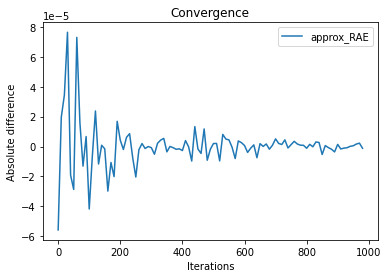

In [237]:
import matplotlib.pyplot as plt

# plot the convergence figure
x = range(0, len(relative_avg_diff) * group_size_K, group_size_K)
plt.plot(x, relative_avg_diff, label='approx_RAE')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Absolute difference')
plt.title('Convergence')
plt.show()

In [238]:
import json

# write results to txt file

num_nodes = len(model.BAG.arguments)
num_edges = len(all_relation)

information = {}
key = str(num_nodes) + "_" + str(num_edges)
information[key] = relative_avg_diff
json_str = json.dumps(information, ensure_ascii=False)

with open('../../bags/node_edge_diff_60_cyclic.txt', 'a') as f:
    f.write(json_str + "\n")